# CD7: full spectrum dimensionality reduction of neutrophils

In this notebook, we perform a clustering analysis of the CD7 data on features extracted from SCIP.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
from scip_workflows.common import *

In [4]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import scale
import anndata
import scanpy
scanpy.settings.verbosity = 3

from sklearn.preprocessing import scale
import flowutils

import scipy.stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

from kneed import KneeLocator

In [5]:
from scip.features import intensity
props = intensity.props.copy()
props.remove("kurtosis")
props.remove("skewness")

In [6]:
def asinh_scale(x, t):
    return scale(flowutils.transforms.asinh(x, channel_indices=None, t=t, m=4.5, a=1), with_std=False)

In [7]:
plt.rcParams['figure.dpi'] = 150

## Data

In [25]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    fillna = bool(int(snakemake.wildcards.fillna))
    output = snakemake.output[0]
except NameError:
    # data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/cd7/800/scip/061020221736/")
    features = data_dir / "features.parquet"
    index = data_dir / "indices" / "index.npy"
    columns = data_dir / "indices" / "columns.npy"
    fillna = False
    output = data_dir / f"adata_{int(fillna)}.h5ad"

In [26]:
df = pq.read_table(features).to_pandas()
df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.loc["D"]
df = df[[c for c in numpy.load(columns, allow_pickle=True) if c in df.columns]]
df = df.loc[numpy.load(index, allow_pickle=True)]
df = df.sort_index()

df.shape

(29927, 1188)

In [27]:
df = df.filter(regex="feat_combined_sum")

## NaN values

In [28]:
df.isna().all(axis=0).any()

False

In [29]:
df.filter(regex="feat").isna().all(axis=1).sum()

0

<AxesSubplot:ylabel='Count'>

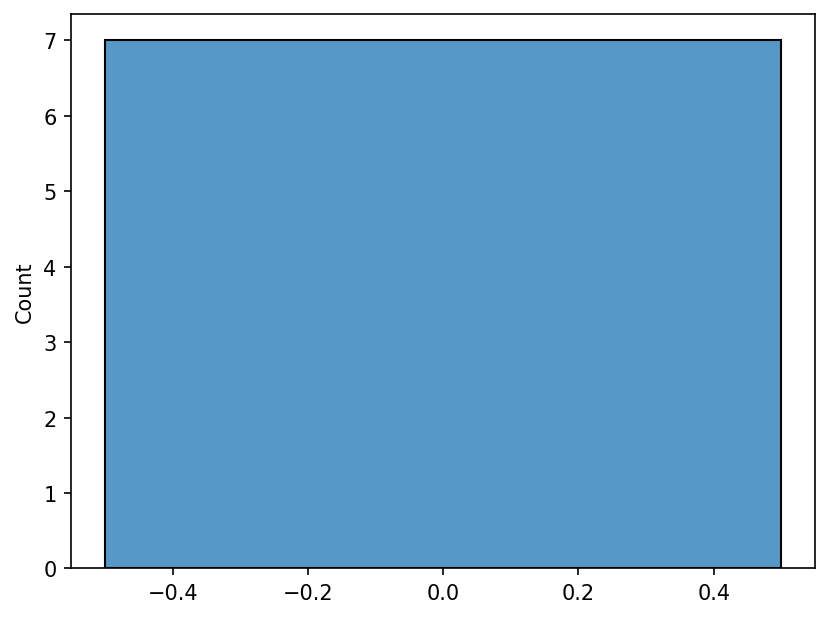

In [30]:
seaborn.histplot(data=df.isna().sum())

## Analysis

In [42]:
obs = df.filter(regex='meta').reset_index()
obs.index = df.index
adata = anndata.AnnData(df.filter(regex="feat").astype(numpy.float32), obs=obs)
adata.raw = adata.copy()

adata.obs["meta_replicate"] = adata.obs["meta_replicate"].astype("category")

In [43]:
markers = [col for col in adata.var.index if col.startswith("feat_sum")]

In [44]:
adata_pre = adata.copy()

computing PCA
    with n_comps=6
    finished (0:00:00)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


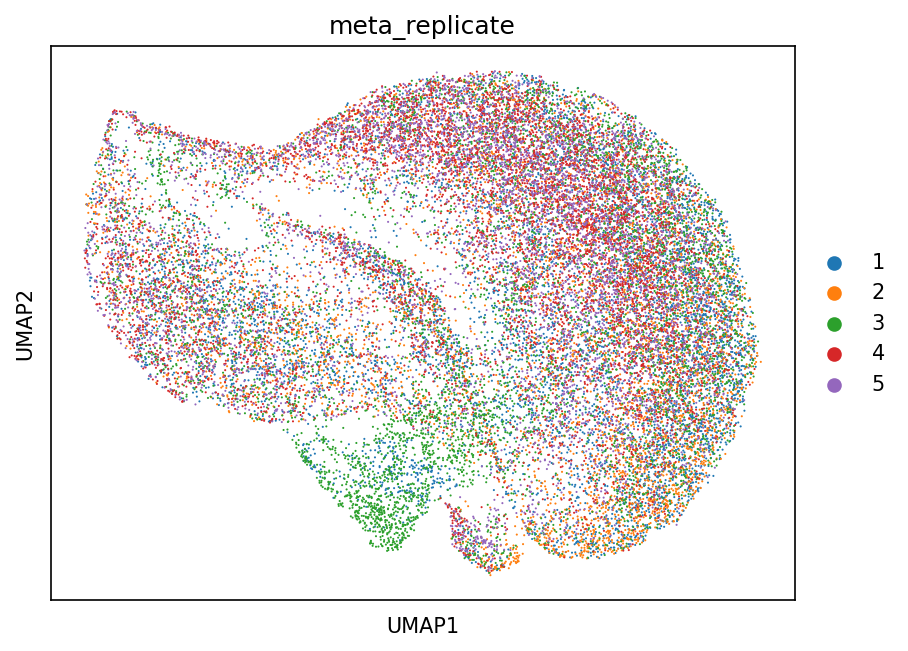

CPU times: user 1min 47s, sys: 9.62 s, total: 1min 57s
Wall time: 50.7 s


In [34]:
%%time
scanpy.pp.scale(adata_pre)
scanpy.tl.pca(adata_pre, svd_solver='arpack')
scanpy.pp.neighbors(adata_pre, n_neighbors=30)
scanpy.tl.umap(adata_pre)
scanpy.pl.umap(adata_pre, color=["meta_replicate"])

In [45]:
adata.var["is_marker"] = [any(n.endswith("feat_combined_sum_%s" % m) for m in ["DAPI", "EGFP", "RPe", "APC"]) for n in adata.var_names]
adata.var["do_asinh"] = [(any(m in n for m in ["DAPI", "EGFP", "RPe", "APC"]) and any(o in n for o in props)) for n in adata.var_names]

In [46]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sc_df = scanpy.get.obs_df(adata, keys=adata.var_names.to_list())
    sc_df[adata.var_names[adata.var.do_asinh].to_list()] = sc_df[adata.var_names[adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: asinh_scale(x, x.max()))
    sc_df[adata.var_names[~adata.var.do_asinh].to_list()] = sc_df[adata.var_names[~adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: scale(x))

adata = anndata.AnnData(X=sc_df, obs=adata.obs, var=adata.var, raw=adata.raw)

CPU times: user 1.57 s, sys: 4.15 ms, total: 1.57 s
Wall time: 1.57 s


In [47]:
def map_names(a):
    return {
        "feat_combined_sum_DAPI": "DAPI",
        "feat_combined_sum_EGFP": "CD45",
        "feat_combined_sum_RPe": "Siglec 8",
        "feat_combined_sum_APC": "CD15"
    }[a]

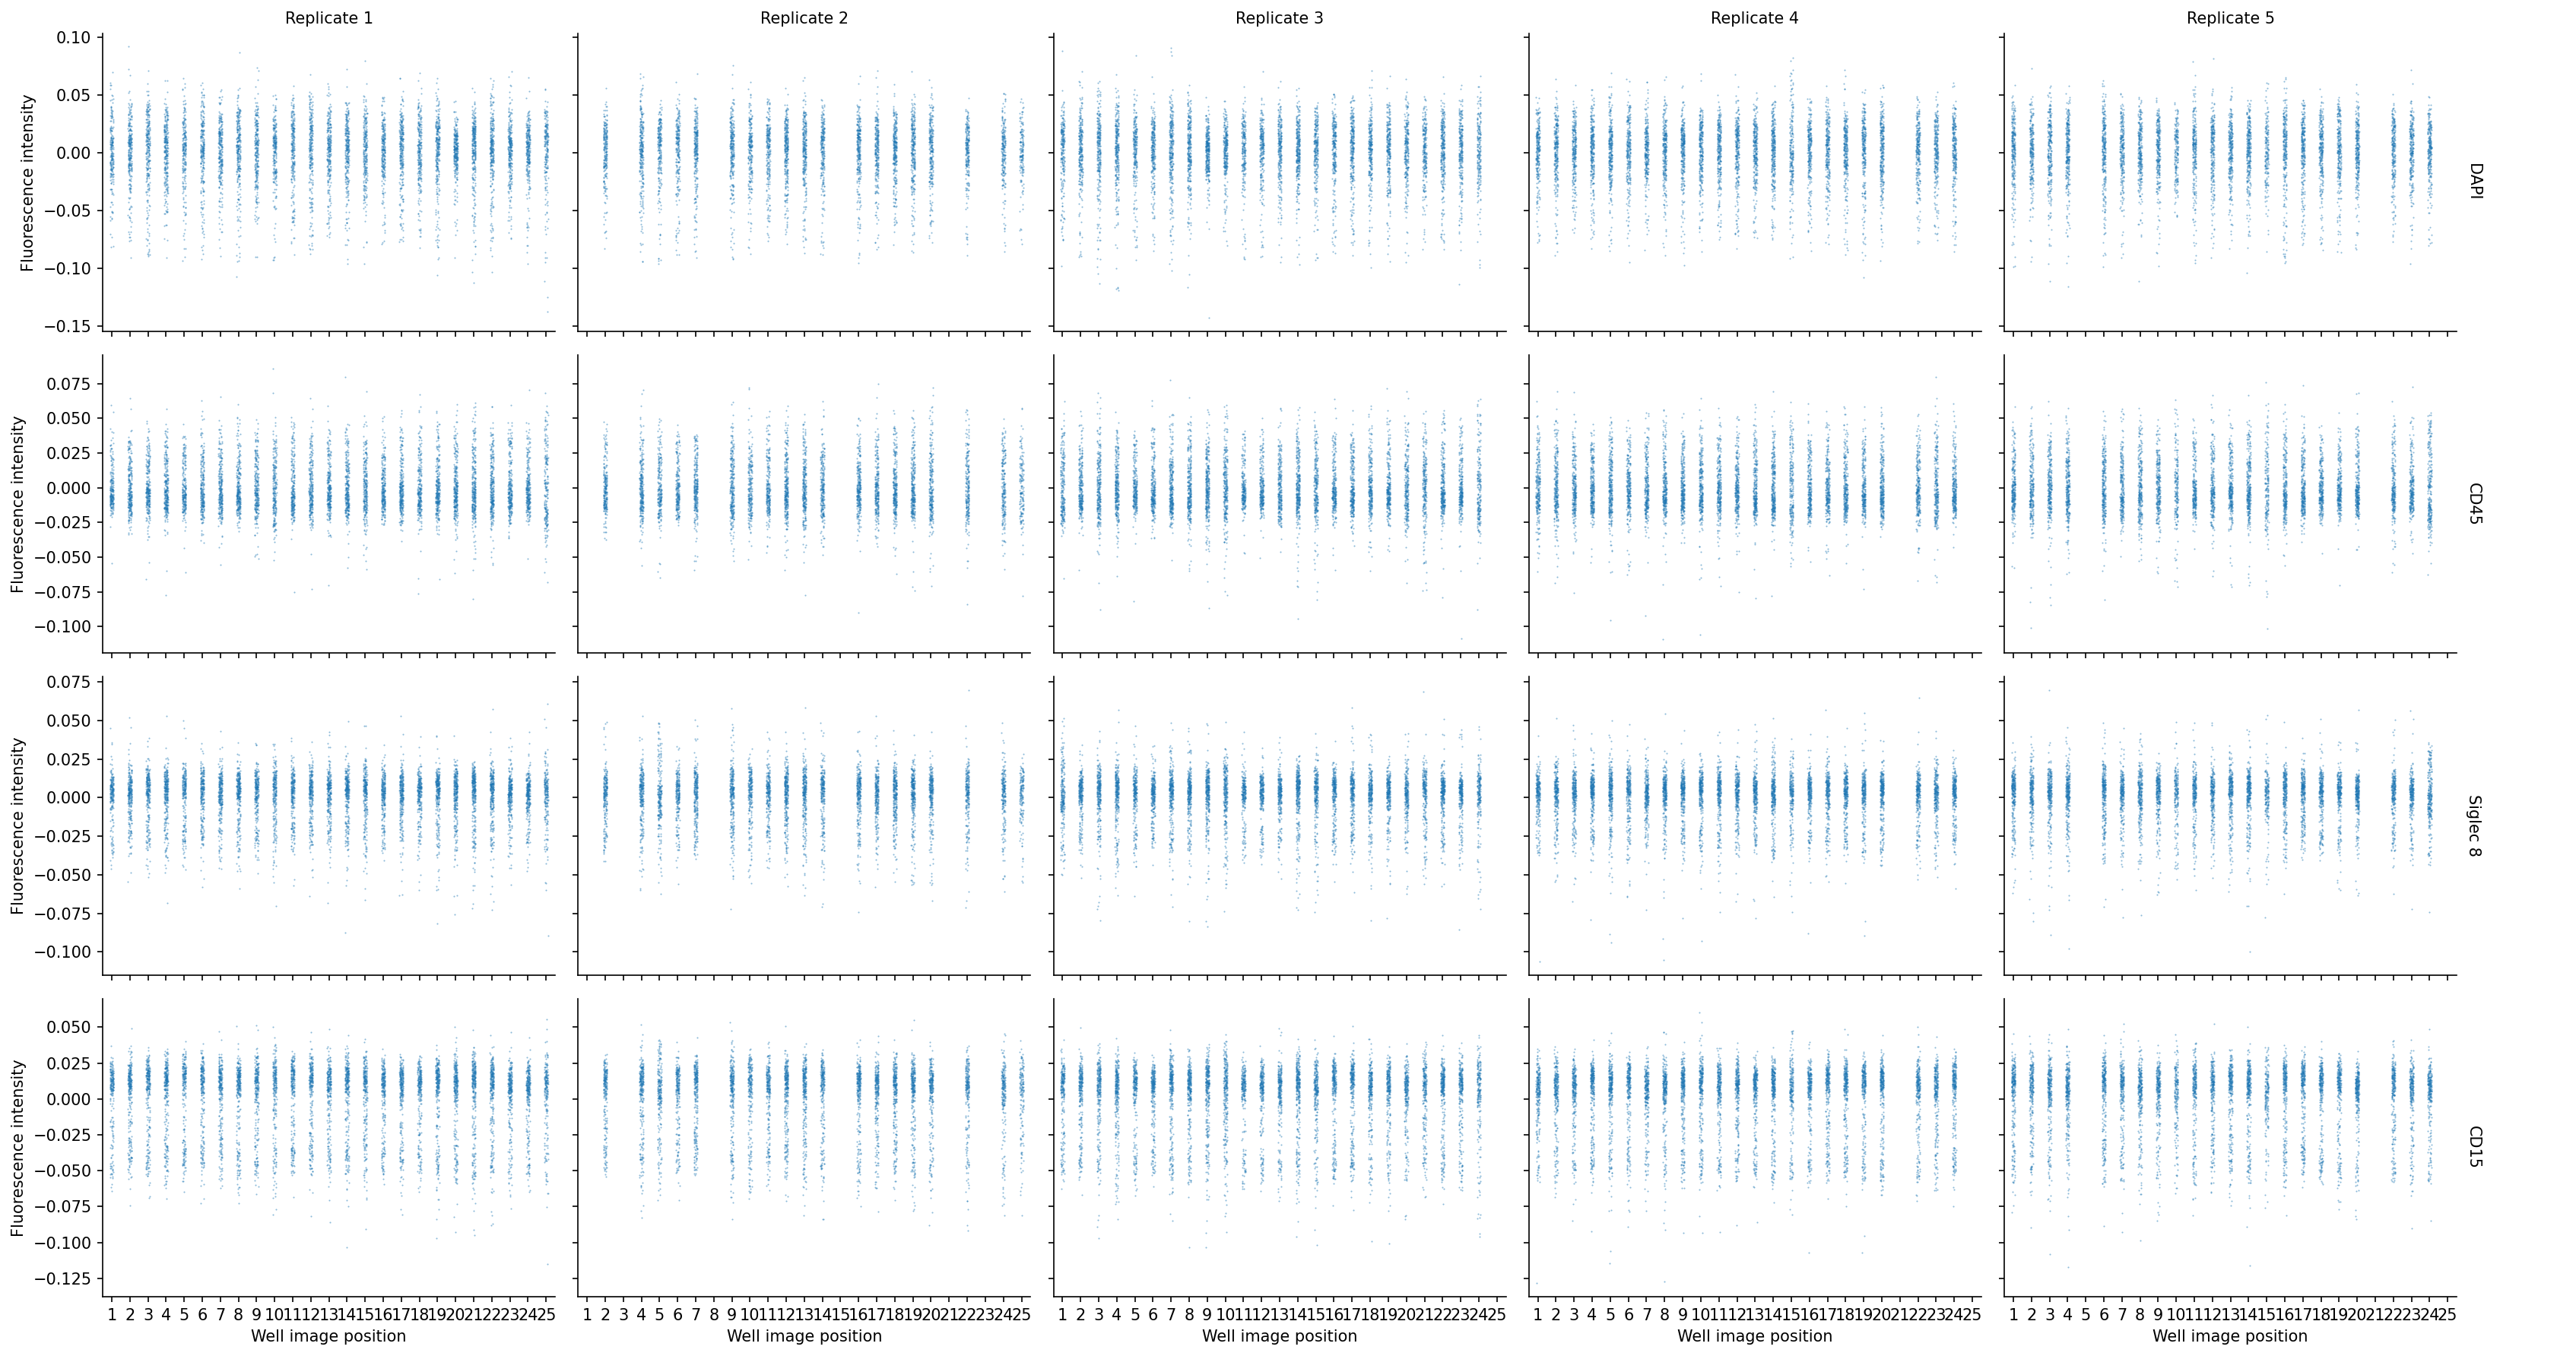

In [60]:
aligned_df = scanpy.get.obs_df(adata, keys=adata.var_names[adata.var.is_marker].to_list()).reset_index()

melted_df = pandas.melt(aligned_df, id_vars=["meta_P", "meta_replicate"], value_vars=adata.var_names[adata.var.is_marker].to_list())
melted_df.variable = melted_df.variable.apply(map_names)

grid = seaborn.FacetGrid(data=melted_df, col="meta_replicate", row="variable", sharey="row", aspect=1.5, margin_titles=True)
grid.map_dataframe(seaborn.stripplot, x="meta_P", y="value", size=1, alpha=0.5)

grid.set_axis_labels("Well image position", "Fluorescence intensity")
grid.set_titles(col_template="Replicate {col_name}", row_template="{row_name}")

grid.add_legend()

# plt.savefig(data_dir / "figures/qc_intensity_distribution_post.png", bbox_inches='tight', pad_inches=0)

In [56]:
scanpy.tl.pca(adata, svd_solver='arpack', random_state=0)
scanpy.pp.neighbors(adata, n_neighbors=5, method="umap", random_state=0)

computing PCA
    with n_comps=6
    finished (0:00:00)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [57]:
%%time
resolutions = [0.1, 0.25, 0.5, 0.75, 1]
for res in resolutions:
    scanpy.tl.leiden(adata, resolution=res, key_added=f"leiden_{res}", random_state=0)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 45 clusters and added
    'leiden_0.75', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 53 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:02)
CPU times: user 10.4 s, sys: 147 ms, total: 10.6 s
Wall time: 10.6 s


In [58]:
scanpy.tl.umap(adata, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


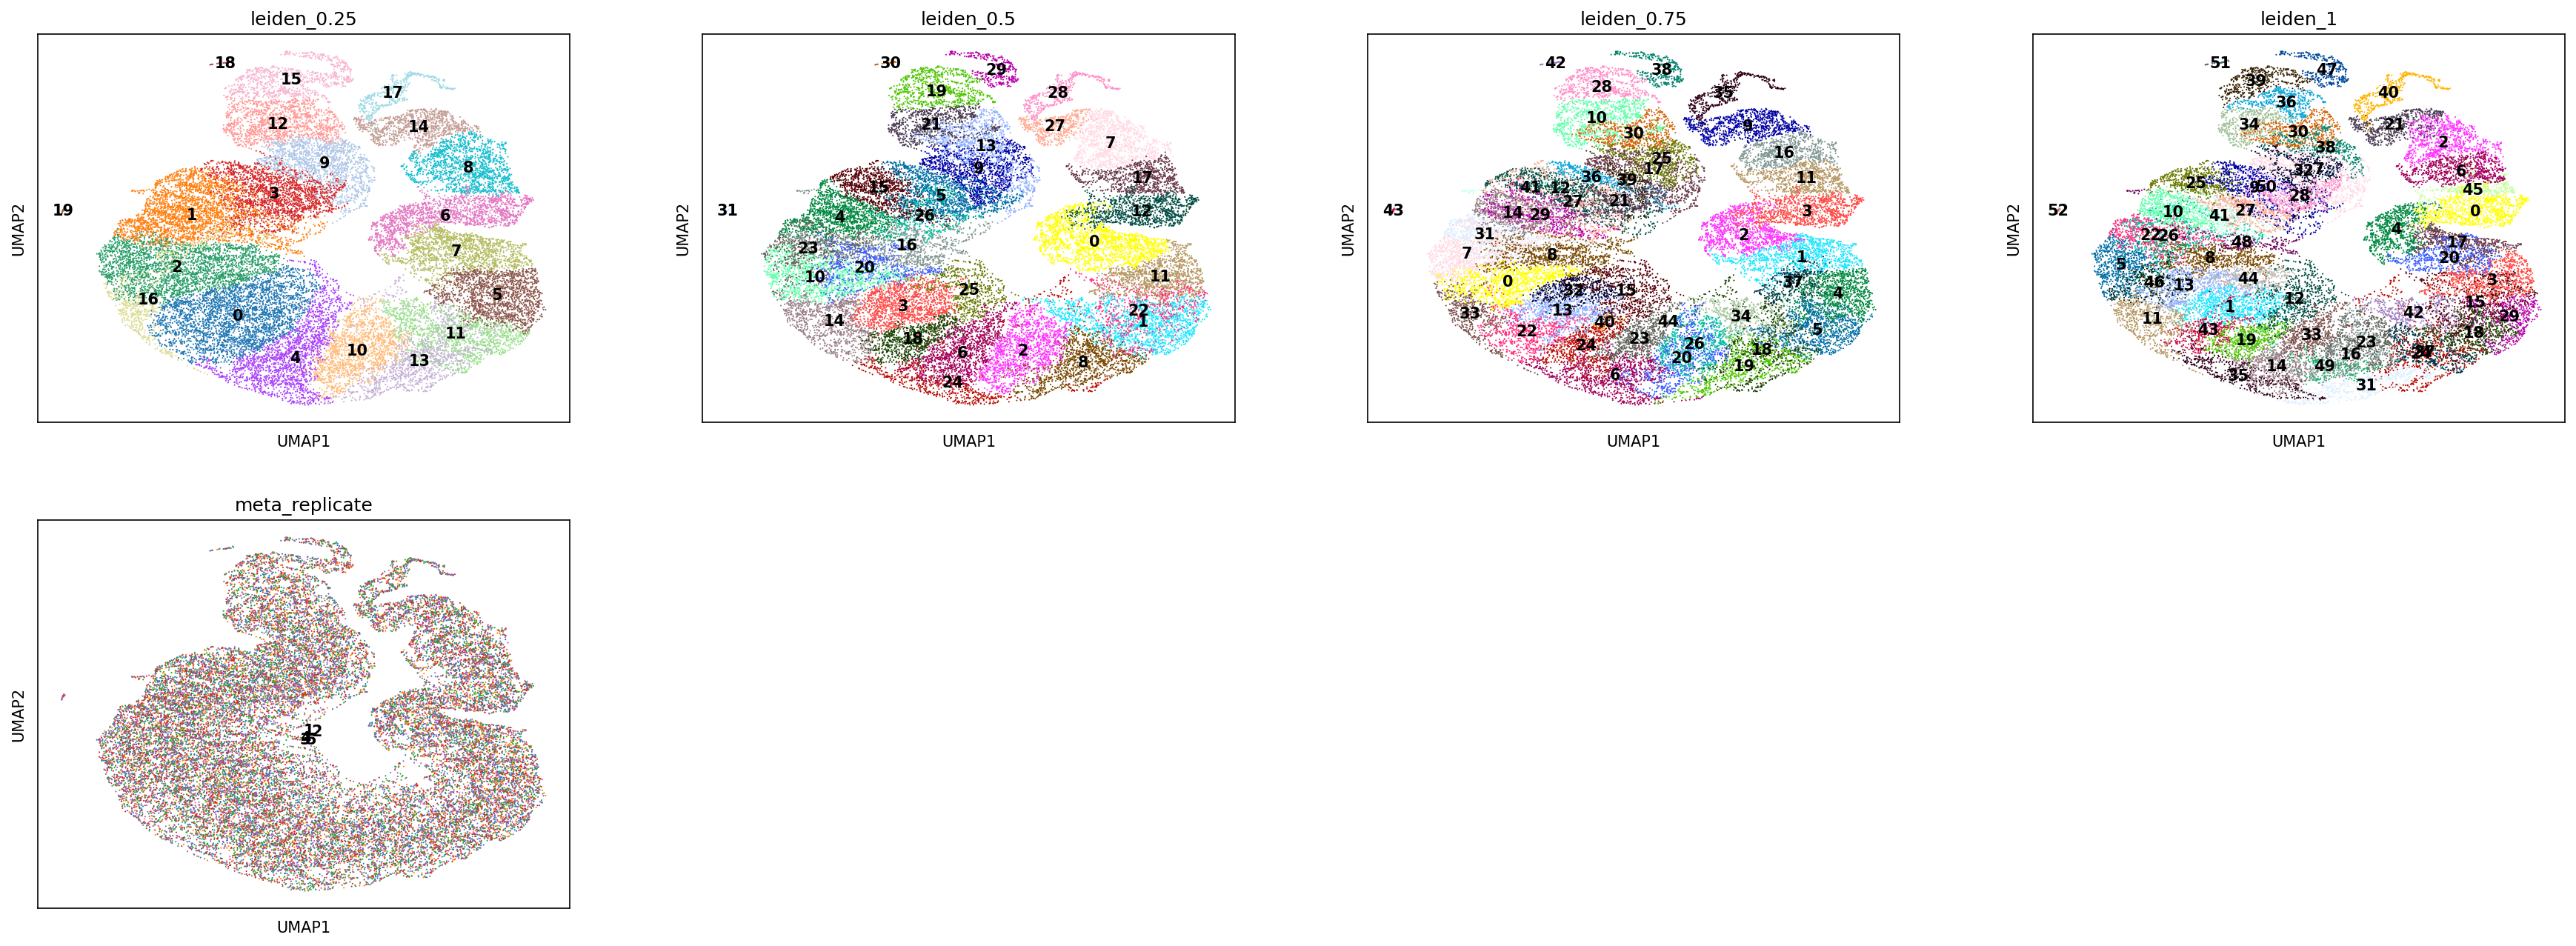

In [59]:
scanpy.pl.umap(adata, color=["leiden_0.25", "leiden_0.5", "leiden_0.75", "leiden_1", "meta_replicate"], legend_loc='on data')

In [54]:
adata.obs["leiden"] = adata.obs["leiden_0.75"]

<AxesSubplot:xlabel='leiden', ylabel='count'>

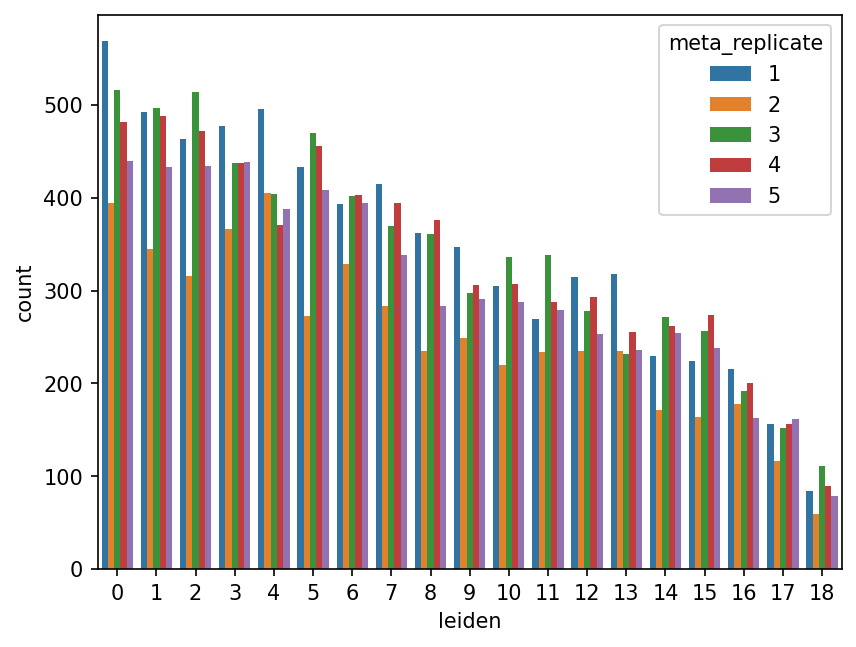

In [55]:
seaborn.countplot(data=adata.obs, x="leiden", hue="meta_replicate")